# Image Recognition Using Keras

Image recognition is the ability of software to identify things (objects, places, people, writing, etc.) in images, i.e. label an image just as a human would by looking at it e.g. ‘This is a car, this image is a banana’ etc.

# VGG16

For Image Recognition, Keras has a number of prebuilt applications. In this tutorial, we shall use an application called VGG16, which is quite popular amongst practitioners.

Simply put, VGG16 is a pretrained neural network model, i.e. it is ready to do work for you. All you have to do is call the predict function. The VGG16 we are going to use was trained on a total of 450,000+ images belonging to 1000 Image Classes, in preparation for the Large Scale Visual Recognition Challenge 2014 (ILSVRC2014). By the way, VGG stands for the name of the group that created this model, i.e. the Visual Geometry Group at University of Oxford

In [1]:
import numpy as np
import keras
from PIL import Image
import scipy.misc
import matplotlib
import matplotlib.pyplot as plt
import io
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
vgg16 = keras.applications.vgg16.VGG16(
            include_top=True, 
            weights='imagenet', 
            input_tensor=None, 
            input_shape=None)

553467904/553467096 [==============================] - 7s 0us/step


Let us try it on a sample image.

In [3]:
URL_IMAGE = "https://rorodata-tmp.s3.amazonaws.com/ring-tailed-lemur.jpg"

In [4]:
!wget $URL_IMAGE

--2018-03-13 05:41:56--  https://rorodata-tmp.s3.amazonaws.com/ring-tailed-lemur.jpg
Resolving rorodata-tmp.s3.amazonaws.com (rorodata-tmp.s3.amazonaws.com)... 52.216.132.163
Connecting to rorodata-tmp.s3.amazonaws.com (rorodata-tmp.s3.amazonaws.com)|52.216.132.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78980 (77K) [image/jpeg]
Saving to: ‘ring-tailed-lemur.jpg.4’

ring-tailed-lemur.j 100%[===================>]  77.13K  --.-KB/s    in 0.002s  

2018-03-13 05:41:56 (49.1 MB/s) - ‘ring-tailed-lemur.jpg.4’ saved [78980/78980]



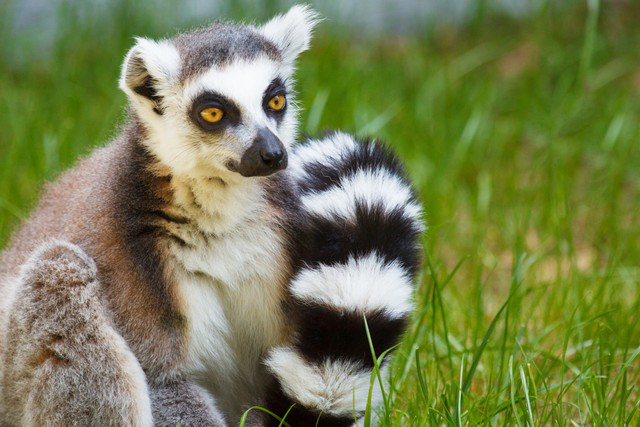

In [5]:
image = Image.open("ring-tailed-lemur.jpg")
image

Now let us try to predict what is inside this image using the vgg16 model.

Because we are using the standard / off-the-shelf model, we need to provide inputs in exactly the format it expects, to get proper outputs. So, in the two lines below, we simply resize the image to a 224x224x3 image (for image clarity, start with a larger image than a smaller image, and resize it). We now reshape it to 1x224x224x3, because that’s what the model expects. In fact, if you wanted to predict n images in one shot, you would provide inputs as an n x 224 x 224 x 3 array.

In [6]:
img=scipy.misc.imresize(image, (224,224))
img=img-127.5 # zero centering the image pixel values gives better accuracies, as the original VGG16 model was trained so
pred=vgg16.predict(img.reshape(1,224,224,3))

# convert pred into a flat array
pred = pred.reshape(-1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.


Remember, pred is a 1000 element long list with probability for it containing each of those labels.

In [7]:
pred.shape

(1000,)

In [8]:
pred[:10]

array([7.2318024e-10, 1.8700952e-10, 1.7514487e-10, 1.5233199e-10,
       1.2578402e-10, 3.3969400e-10, 4.2112046e-11, 6.7779791e-09,
       1.2214648e-08, 9.4316221e-07], dtype=float32)

What is the label with highest probability?

In [9]:
pred.argmax()

383

In [10]:
pred[383]

0.93914855

In [11]:
# if you want to find the top 3 labels
pred.argsort()[::-1][:3]

array([383, 384, 362])

vgg16 thinks that our picture has object 383. How do we find what that is?

The class labels are available online. Let us download it.

In [12]:
import requests
URL_CLASS_LABELS = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
class_labels = requests.get(URL_CLASS_LABELS).json()

In [13]:
class_labels['383']

['n02497673', 'Madagascar_cat']

In [13]:
class_labels['384']

['n02500267', 'indri']

Let us write small function to make it easier to use.

In [14]:
def get_class_label(index):
    return class_labels[str(index)][1]

Now let us write a function to predict what is available in a URL.

In [15]:
def predict(image):
    img=scipy.misc.imresize(image, (224,224))
    img=img-127.5 # zero centering the image pixel values gives better accuracies, as the original VGG16 model was trained so
    pred=vgg16.predict(img.reshape(1,224,224,3))

    # convert pred into a flat array
    pred = pred.reshape(-1)
    index = pred.argmax()
    return get_class_label(index)

In [16]:
predict(image)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


'Madagascar_cat'

In [17]:
def predict_url(url):
    image = read_image(url)
    return predict(image)

def read_image(url):
    data = requests.get(url).content
    return Image.open(fp=io.BytesIO(data))


In [18]:
predict_url(URL_IMAGE)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


'Madagascar_cat'

## Deploying the API

Write a `predict.py` and run it as API locally to test using:

    firefly predict.predict

In [19]:
import firefly
api = firefly.Client("http://localhost:8000/")

In [22]:
api.predict(image={"url": URL_IMAGE})

'Madagascar_cat'

In [23]:
URL_IMAGE

'https://rorodata-tmp.s3.amazonaws.com/ring-tailed-lemur.jpg'

In [23]:
api = firefly.Client("https://deeplearning-image--api.rorocloud.io/")

In [28]:
api.predict(image={"url": URL_IMAGE})

[{'label': 'Madagascar_cat', 'probability': 0.9391485452651978},
 {'label': 'indri', 'probability': 0.03895948827266693},
 {'label': 'badger', 'probability': 0.021054944023489952}]